--------------------------FOR FINAL DEMO PLEASE INITIATE GRADIO AND ADD IMAGES THROUGH THE INTERFACE----------------------------

In [1]:
#Importing Libraries
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import math
import gradio

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
#Getting directories

style_dir=r'C:\Users\Shirshak\Tensorflow Tutorials\Neural Style Transfer\style'

content_dir=r'C:\Users\Shirshak\Tensorflow Tutorials\Neural Style Transfer\content'

In [17]:
#Loading the images
style=Image.open(style_dir+'\style9.jfif')
content=Image.open(content_dir+'\content2.jpg')

style=np.array(style)
content=np.array(content)

In [18]:
def load_img(img):
    max_dim = 512
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(np.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [19]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

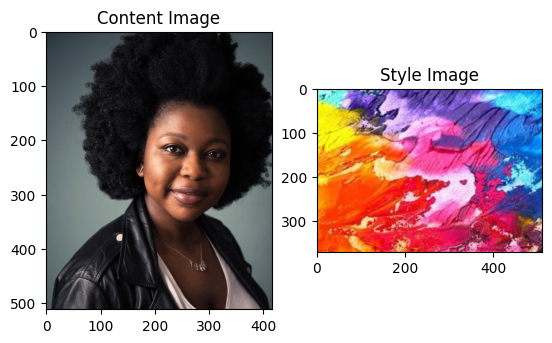

In [20]:
content_image = load_img(content)
style_image = load_img(style)


plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')


In [21]:
#Function to preprocess image
def display(img):
    fig = plt.figure(figsize=(8, 8))
    for j,i in enumerate(img):
        image=np.array(i)
        fig.add_subplot(math.ceil(len(img)/4),len(img),j+1)
        plt.imshow(image,interpolation='nearest')
    plt.show()

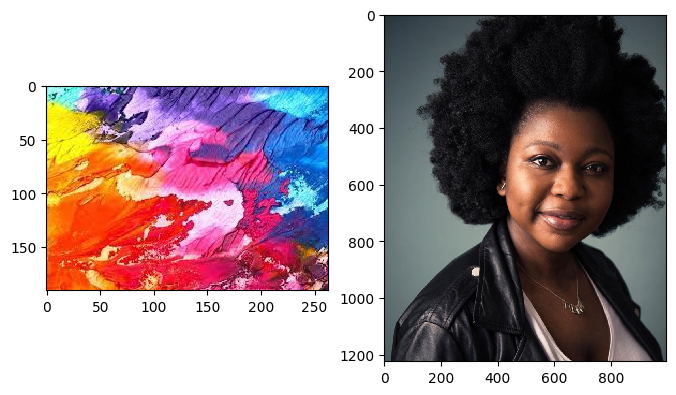

In [22]:
display([style,content])

In [25]:
#Loading the VGG 16 model 
x = tf.keras.applications.vgg16.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg=tf.keras.applications.vgg16.VGG16(weights='imagenet',include_top=True)
prediction_probabilities = vgg(x)
prediction_probabilities.shape

In [69]:
predicted_top_5 = tf.keras.applications.vgg16.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('bow', 0.5388888),
 ('swing', 0.08798401),
 ('drumstick', 0.015038437),
 ('gong', 0.014826094),
 ('wooden_spoon', 0.01417827)]

In [15]:
vgg=tf.keras.applications.vgg16.VGG16(weights='imagenet',include_top=False)
for layer in vgg.layers:
    print(layer.name)

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [26]:
#Selecting our layers based on Jhon el
def layers():
    style_layers=['block1_conv2',
                  'block2_conv2',
                  'block3_conv3',
                  'block4_conv3',
                  'block5_conv3']
    
    content_layers=['block2_conv2']
    
    return style_layers,content_layers

In [27]:
#building our model
def vgg_layer(layers):
    vgg=vgg=tf.keras.applications.VGG16(weights='imagenet',include_top=False) #Reinstantiating the model with dense layers removed
    vgg.trainable=False #Freezing the layers
    
    outputs=[vgg.get_layer(layer).output for layer in layers] #Getting the activations of the different layers
    model=tf.keras.Model([vgg.input],outputs)
    return model

In [28]:
style_layers,content_layers=layers()

In [29]:
def gram_matrix(activation):
    result=tf.linalg.einsum('bijc,bijd->bcd',activation,activation) #This will caluculate the norm of the dot product of the activation and it's transpose
    nW,nH=activation.shape[0],activation.shape[1]
    
    #coefficient=nW*nH #calculating the coefficient
    coefficient = tf.cast(activation.shape[1]*activation.shape[2], tf.float32)
    return result/coefficient

In [30]:
#Here the Model class is base class and the NST class is the derived class
class NST(tf.keras.models.Model):
    def __init__(self,style_layers,content_layers):
        super(NST, self).__init__()
        self.vgg=vgg_layer(style_layers+content_layers)
        self.style_layers=style_layers
        self.content_layers=content_layers
        self.num_layers=len(style_layers)
        self.vgg.trainable=False
    
    def call(self,image):
        preprocessed_input=tf.keras.applications.vgg16.preprocess_input(image*255) #Preprocessing image to vgg 16's input
        #preprocessed_input=tf.image.resize(preprocessed_input, (224, 224))
        output=self.vgg(preprocessed_input) #Receiving the activations of the defined layers
        
        #Getting the style and content activations 
        style_activations,content_activations=output[:self.num_layers],output[self.num_layers:]
        style_outputs=[gram_matrix(layer) for layer in style_activations] #Generating the gram matrix for each of the activation layers 
        
        #Storing in a dictionary 
        content_dict = {content_name: value
                    for content_name, value in zip(self.content_layers, content_activations)}
        
        style_dict = {style_name: value
                  for style_name, value in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

In [31]:
Layer_extractor=NST(style_layers,content_layers)

In [32]:
results = Layer_extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())

Styles:
   block1_conv2
    shape:  (1, 64, 64)
    min:  13.644796
    max:  270520.38
    mean:  9250.187

   block2_conv2
    shape:  (1, 128, 128)
    min:  0.21843396
    max:  651847.9
    mean:  21756.848

   block3_conv3
    shape:  (1, 256, 256)
    min:  17.364796
    max:  609768.56
    mean:  15913.708

   block4_conv3
    shape:  (1, 512, 512)
    min:  0.0
    max:  107241.25
    mean:  248.35324

   block5_conv3
    shape:  (1, 512, 512)
    min:  0.0
    max:  350.61053
    mean:  0.2753036

Contents:
   block2_conv2
    shape:  (1, 256, 208, 128)
    min:  0.0
    max:  8099.8022
    mean:  127.30441


In [57]:
#Initializing our alpha and beta
alpha=1e-1
beta=1e2

In [34]:
#Initialing our generated image
image=tf.Variable(content_image)

In [35]:
#Defining style loss
def style_loss_func(style_target,style_output):
    loss_style=tf.add_n([tf.reduce_mean((style_output[layer]-style_target[layer])**2)
                                       for layer in style_output.keys()])
    num_layers_style=len(style_layers)
    coeff=alpha/num_layers_style
    loss_style*=coeff
    return loss_style

In [36]:
#Defining content loss
def content_loss_func(content_target,content_output):
    loss_content=tf.add_n([tf.reduce_mean((content_output[layer]-content_target[layer])**2)
                                       for layer in content_output.keys()])
    num_layers_content=len(content_layers)
    coeff=beta/num_layers_content
    loss_content*=coeff
    return loss_content

In [37]:
#Keeping pixel values between 0 and 1
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [38]:
#Setting optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [39]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [47]:
#Test FUNCTION
# @tf.function()
# def train_step(content_target,style_target,image):
#     with tf.GradientTape() as tape:
#         outputs = Layer_extractor(image)
#         style_loss = style_loss_func(outputs['style'])
#         content_loss = content_loss_func(outputs['content'])
#         loss=style_loss+content_loss
#         loss += total_variation_weight*tf.image.total_variation(image)

#     grad = tape.gradient(loss, image)
#     opt.apply_gradients([(grad, image)])
#     image.assign(clip_0_1(image))

In [43]:
# TEST RUNS
#Running a complete run

epochs=5
steps_per_epoch=100
for epoch in range(epochs):
    for step in range(steps_per_epoch):
        step+=1
        train_step(image)
print(f"Total Step:{step}")

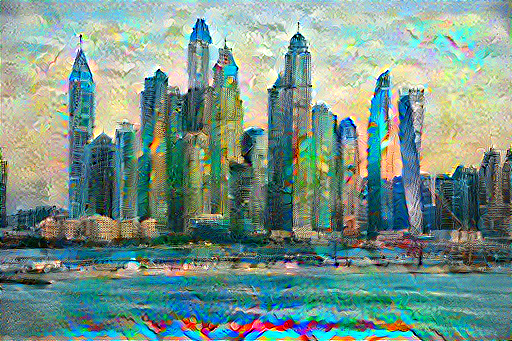

In [71]:
tensor_to_image(image)

## Total Variation Loss

In [44]:
def high_pass_x_y(image):
    x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
    y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

    return x_var, y_var

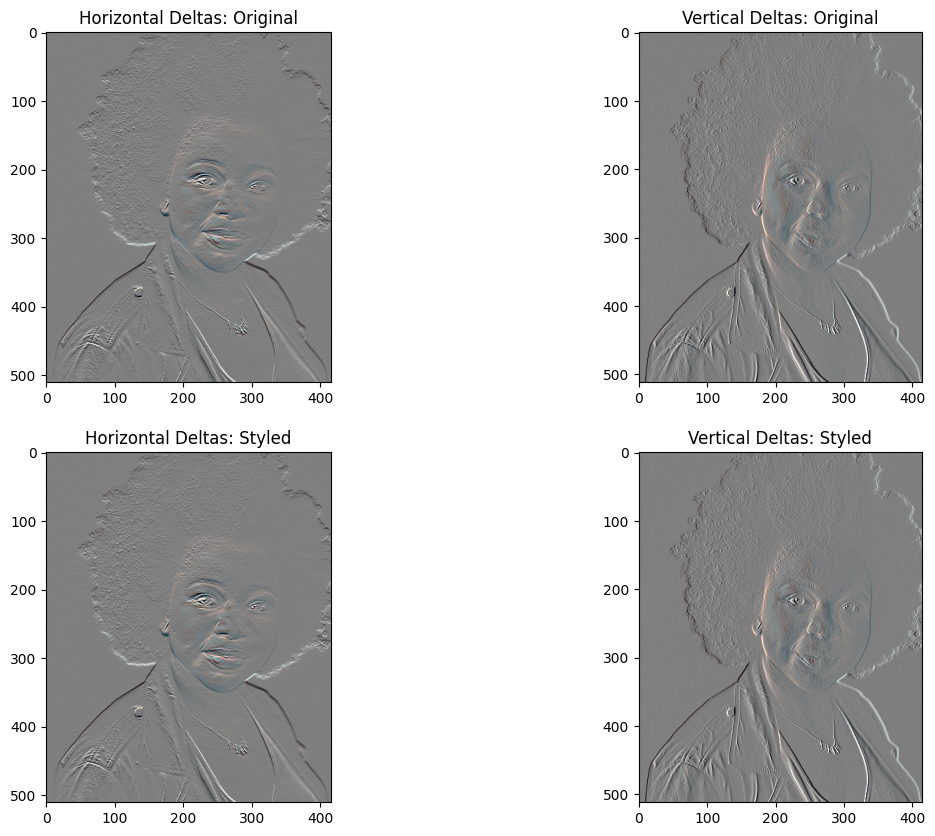

In [45]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

In [46]:
total_variation_weight=1

In [48]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

In [49]:
tf.config.run_functions_eagerly(True)

In [54]:
#Setting up gradient descent
@tf.function()
def train_step(content_target,style_target,image):
    with tf.GradientTape() as tape:
        outputs = Layer_extractor(image)
        style_loss = style_loss_func(style_target,outputs['style'])
        content_loss = content_loss_func(content_target,outputs['content'])
        loss=style_loss+content_loss
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [ ]:
# ----- FOR TESTING WITHOUT GRADIO--------------
image=tf.Variable(content_image)
style_target=Layer_extractor(style_image)['style']
content_target=Layer_extractor(content_image)['content']
epochs=5
steps_per_epoch=100
for epoch in range(epochs):
    for step in range(steps_per_epoch):
        step+=1
        train_step(content_target,style_target,image)
image1=tensor_to_image(image)

In [50]:
#Gradio Function

def train(content1,style1):
    content_image=load_img(content1)
    style_image=load_img(style1)
    image=tf.Variable(content_image)
    style_target=Layer_extractor(style_image)['style']
    content_target=Layer_extractor(content_image)['content']
    epochs=5
    steps_per_epoch=100
    for epoch in range(epochs):
        for step in range(steps_per_epoch):
            step+=1
            train_step(content_target,style_target,image)
    image1=tensor_to_image(image)
    return image1

In [58]:
gr=gradio.Interface(fn=train,inputs=['image','image'],outputs='image')
gr.launch(share=False)

IMPORTANT: You are using gradio version 3.6, however version 3.14.0 is available, please upgrade.
--------
Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


(<gradio.routes.App at 0x2bc676d20a0>, 'http://127.0.0.1:7863/', None)

In [51]:
#Denoising the image 
from skimage.restoration import denoise_tv_chambolle

In [481]:
img=np.array(img)

In [59]:
denoised_img=denoise_tv_chambolle(img,
    weight=0.1,
    eps=0.0002,
    max_num_iter=200,
    multichannel=True,
    channel_axis=None,)

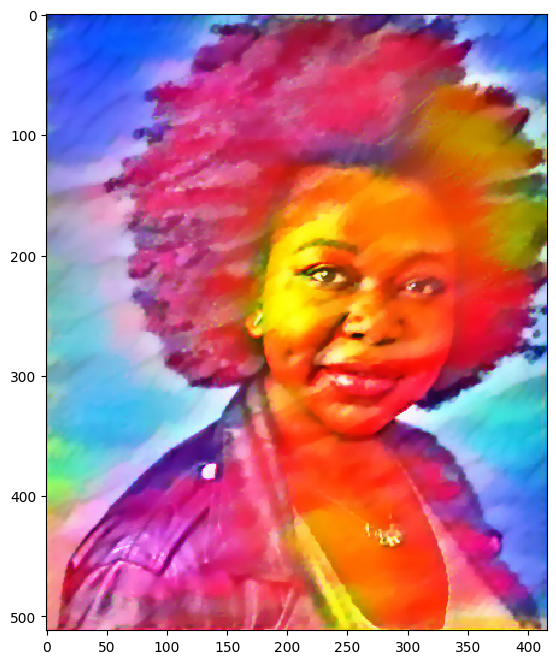

In [398]:
display([denoised_img])